In [1]:
from FIG import FIG
import numpy as np
# Temporary PHATE / graphtools
if not hasattr(np, "float"):
    np.float = float
from PHATET import PHATET

In [2]:
from scipy import io
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load EEG data
data = io.loadmat(r'n10_8-12hz.mat')
eeg = np.transpose(data['data'])

# select all channels
Data_eeg = eeg[:,:]

# load the labels
labels_d = pd.read_excel('labelsn10.xlsx')
labels = np.array(labels_d['Unnamed: 7'])
labels  = np.reshape(labels[:860], 860)

# check the dim of the data
print(Data_eeg.shape)

time_lab = np.arange(860)

(3302400, 18)


In [3]:

# here is how to implement FIG 
L1 = 3840
L3 = 3840
L2 = 50
fig = FIG(
    Data_eeg,
    window_size=L2,
    n_components=3,
    normalization="sqrt",
    lift_type="fourier",
    num_basis=7,
    period=10,
    center_window=L1,
    center_stride=L3,
)

MD = fig.fit()
print(MD.shape)  # (n_centers, n_centers)


(860, 860)


In [4]:
# --- PHATE on FIG distance ---
phate_10d = PHATET(
    knn_dist="precomputed_distance",
    k=20,
    n_components=10,
    verbose=0
)
Z_10d = phate_10d.fit_transform(MD)

# --- Visualization embeddings ---
phate_3d = PHATET(n_components=3, k=20, verbose=0)
phate_2d = PHATET(n_components=2, k=20, verbose=0)
fig_2d = phate_2d.fit_transform(Z_10d)

/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 555 with stress 0.32919896180950675


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 91 with stress 21048.527238046707


In [5]:
# here is how to implement FIG 
L1 = 3840
L3 = 3840
L2 = 50
fig = FIG(
    Data_eeg,
    window_size=L2,
    n_components=3,
    normalization="sqrt",
    lift_type="rbf",
    num_basis=100,
    #period=10,
    center_window=L1,
    center_stride=L3,
)

MD_rbf = fig.fit()
print(MD_rbf.shape)  # (n_centers, n_centers)


(860, 860)


In [6]:
Z_10d_rbf = phate_10d.fit_transform(MD_rbf)
fig_2d_rbf = phate_2d.fit_transform(Z_10d_rbf)

/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 672 with stress 2.389201955801224


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 110 with stress 20115.429206398712


In [7]:
# Make a copy so we don't destroy the original labels
labels_merged = labels.copy()

# Merge sleep stages
labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1-S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3-S4

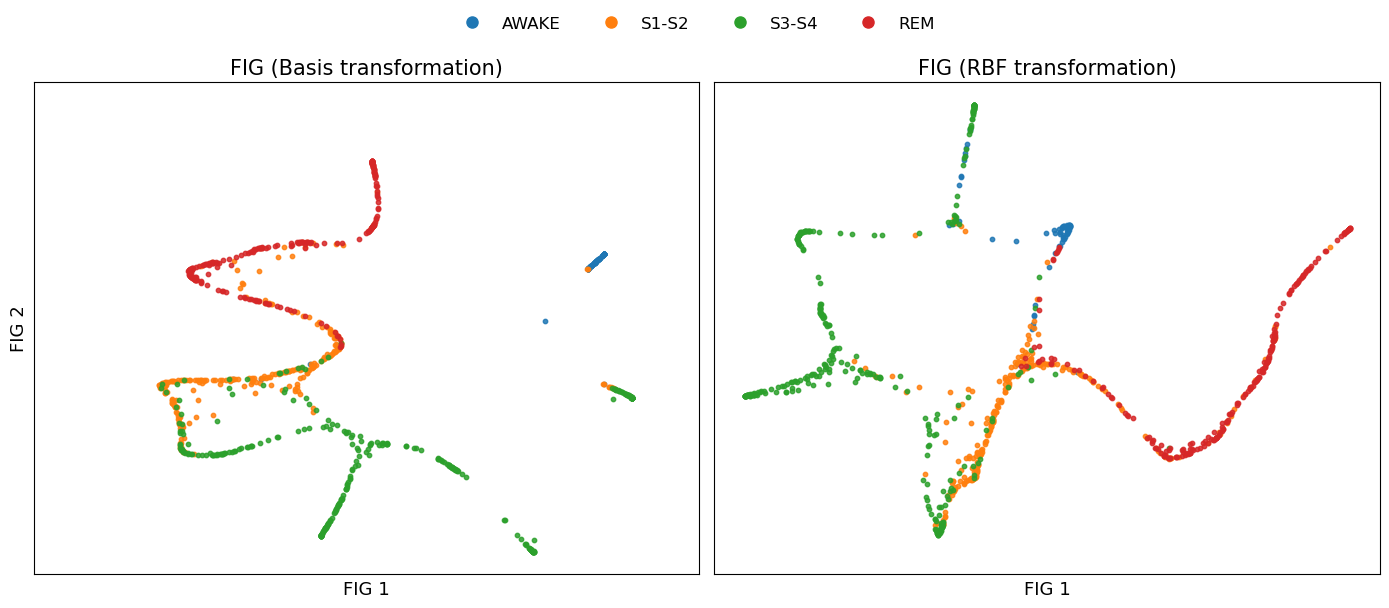

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---------------------------------------------------
# Ensure labels are integers
# ---------------------------------------------------
labels_plot = labels_merged.astype(int)
unique_labels = np.unique(labels_plot)

# ---------------------------------------------------
# Legend mapping
# ---------------------------------------------------
legend_dict = {
    0: "AWAKE",
    2: "S1-S2",
    4: "S3-S4",
    5: "REM"
}

# ---------------------------------------------------
# Consistent color map
# ---------------------------------------------------
cmap = plt.cm.tab10
color_map = {lab: cmap(i) for i, lab in enumerate(unique_labels)}

# ---------------------------------------------------
# Create side-by-side plots
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

titles = [
    "FIG (Basis transformation)",
    "FIG (RBF transformation)"
]

embeddings = [fig_2d, fig_2d_rbf]

for ax, emb, title in zip(axes, embeddings, titles):
    for lab in unique_labels:
        mask = labels_plot == lab
        ax.scatter(
            emb[mask, 0],
            emb[mask, 1],
            s=10,
            alpha=0.85,
            color=color_map[lab],
            rasterized=True
        )

    ax.set_title(title, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_ylabel("FIG 2", fontsize=13)
axes[0].set_xlabel("FIG 1", fontsize=13)
axes[1].set_xlabel("FIG 1", fontsize=13)

# ---------------------------------------------------
# Shared legend
# ---------------------------------------------------
legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=8,
        color=color_map[lab],
        label=legend_dict[lab]
    )
    for lab in unique_labels
]

fig.legend(
    handles=legend_handles,
    fontsize=12,
    frameon=False,
    loc="upper center",
    ncol=len(unique_labels),
    bbox_to_anchor=(0.5, 1.02)
)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()
